# Projet Deep Learning pour aider au ramassage de champignon en foret

on fait les installations

In [78]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

on indique le chemin vers le dataset de 3000 photos de champignons

In [79]:
path = "/content/gdrive/MyDrive/archive"
fns = get_image_files(path)
fns

(#3401) [Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (136).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (184).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (16).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (202).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (212).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (120).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (11).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (247).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (194).jpg'),Path('/content/gdrive/MyDrive/archive/edible mushroom sporocarp/ce (171).jpg')...]

In [81]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
mushrooms = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = mushrooms.dataloaders(path)

on vérifie que ça charge correctement

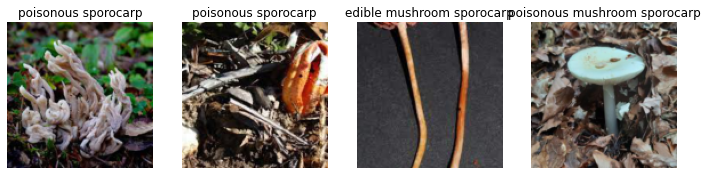

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

ensuite on fait de la data augmentation


In [ ]:
#hide_output
mushrooms = mushrooms.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = mushrooms.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


on fait un entrainement

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.510821,0.823940,0.291176,03:03


epoch,train_loss,valid_loss,error_rate,time
0,0.910990,0.649552,0.236765,00:45
1,0.791099,0.640913,0.230882,00:45
2,0.599340,0.546074,0.182353,00:45
3,0.465363,0.530958,0.179412,00:45


on fait la matrice de confusion pour vérifier la précision

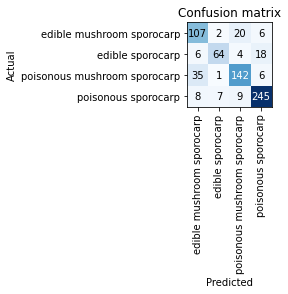

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

c'est pas super sauf pour les poisonous sporocap

mais on va faire un test quand meme

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide_output
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
is_edible,_,probs = learn.predict(img)
print(f"It's probably a : {is_edible}.")
print(f"With a probability of : {probs[1].item():.6f}")

It's probably a : edible sporocarp.
With a probability of : 0.393399


d'après wikipédia c'est un [coprin pie](https://fr.wikipedia.org/wiki/Coprin_pie) et c'est en effet un champignon comestible si jeune, sinon il serait légérement toxique, celui que j'ai en photo est donc commestible en théorie.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.463319,0.846581,0.294118,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.923084,0.670519,0.252941,01:09
1,0.716780,0.590163,0.185294,01:09
2,0.503471,0.523276,0.157353,01:09
3,0.370630,0.498523,0.158824,01:09


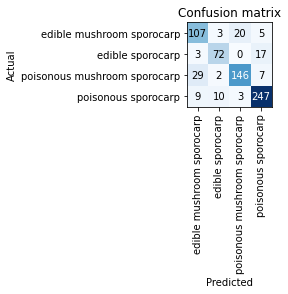

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

la matrice de confusion est très similaire on va predire sur la meme image

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide_output
img = PILImage.create(btn_upload.data[-1])
is_edible,_,probs = learn.predict(img)
print(f"It's probably a : {is_edible}.")
print(f"With a probability of : {probs[1].item():.6f}")

It's probably a : edible sporocarp.
With a probability of : 0.606078


la prédiction est différente l'algorithme à l'air plus sûr de lui.

on va tenter avec plus d'epoch

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.522722,0.846382,0.291176,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.960581,0.693489,0.257353,00:45
1,0.790414,0.638708,0.225000,00:45
2,0.677549,0.613843,0.202941,00:46
3,0.544836,0.560408,0.194118,00:45
4,0.444481,0.540702,0.172059,00:46
5,0.353865,0.542403,0.169118,00:47
6,0.268593,0.578261,0.167647,00:46
7,0.216843,0.568651,0.163235,00:45
8,0.181190,0.551731,0.163235,00:46
9,0.166163,0.549002,0.161765,00:46


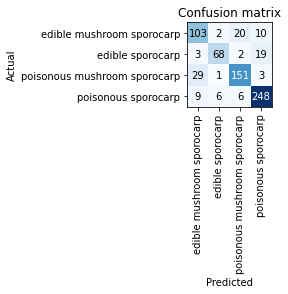

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide_output
img = PILImage.create(btn_upload.data[-1])
is_edible,_,probs = learn.predict(img)
print(f"It's probably a : {is_edible}.")
print(f"With a probability of : {probs[1].item():.6f}")

It's probably a : poisonous sporocarp.
With a probability of : 0.157085


resultat différent on peut voir que c'est moins précis qu'en resnet34 mais classer le champignon en toxique a 15% est plus raisonnable, car le champignon est au mieux fade, et odorant il est au pire légèrement toxique et on ne veut pas de procès de gens qui ont aveuglement cru l'algo

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.556058,0.872458,0.302941,00:54


epoch,train_loss,valid_loss,error_rate,time
0,0.884907,0.672362,0.250000,01:10
1,0.727567,0.686943,0.239706,01:10
2,0.571331,0.693402,0.232353,01:10
3,0.458800,0.594764,0.185294,01:10
4,0.334043,0.591024,0.188235,01:10
5,0.251305,0.587464,0.158824,01:11
6,0.186955,0.604155,0.163235,01:11
7,0.135717,0.546347,0.151471,01:10
8,0.107028,0.533989,0.148529,01:10
9,0.091386,0.545465,0.139706,01:10


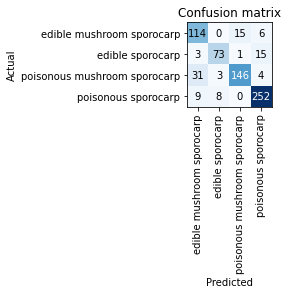

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide_output
img = PILImage.create(btn_upload.data[-1])
is_edible,_,probs = learn.predict(img)
print(f"It's probably a : {is_edible}.")
print(f"With a probability of : {probs[1].item():.6f}")

It's probably a : edible mushroom sporocarp.
With a probability of : 0.426789


Maintenant on va spécialiser pour les champignons trouvables en france après avoir exporter le modèle

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict(img)

('edible mushroom sporocarp',
 TensorBase(0),
 TensorBase([4.9561e-01, 4.2679e-01, 3.9084e-05, 7.7568e-02]))

In [ ]:
learn_inf.dls.vocab

['edible mushroom sporocarp', 'edible sporocarp', 'poisonous mushroom sporocarp', 'poisonous sporocarp']

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'key')

In [ ]:
path = Path('champisFR')
if not path.exists():
    path.mkdir()
    for o in learn_inf.dls.vocab:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} mushroom forest france')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#583) [Path('champisFR/poisonous mushroom sporocarp/00000099.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000098.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000129.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000132.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000146.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000003.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000042.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000113.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000045.jpg'),Path('champisFR/poisonous mushroom sporocarp/00000131.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


(#0) []

In [ ]:
failed.map(Path.unlink);

In [ ]:
champisFR = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=9),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = champisFR.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


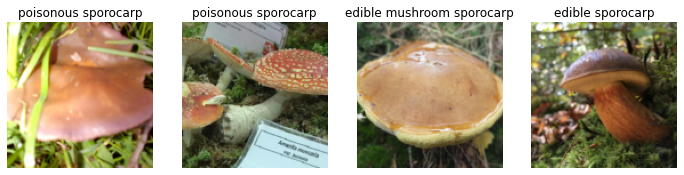

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
champisFR = champisFR.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = champisFR.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.666157,2.037078,0.724138,00:32


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


epoch,train_loss,valid_loss,error_rate,time
0,2.016567,1.953313,0.758621,00:32
1,1.887812,2.049371,0.758621,00:32
2,1.651469,2.069623,0.741379,00:32
3,1.519193,2.053318,0.732759,00:34


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 158752 bytes but only got 52067. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


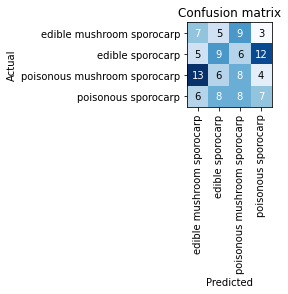

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

on peut voir qu'automatisé avec azure les résultats sont peu concluants

je vais simplifier en faisant 2 catégories

In [82]:
path = "/content/gdrive/MyDrive/champis"
fns = get_image_files(path)
fns

(#3401) [Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (551).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (550).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (549).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (548).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (547).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (546).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (545).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (544).jpg'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (2).png'),Path('/content/gdrive/MyDrive/champis/poisonous mushroom/cv (1).png')...]

In [83]:
mushrooms = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [84]:
dls = mushrooms.dataloaders(path)

In [85]:
#hide_output
mushrooms = mushrooms.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = mushrooms.dataloaders(path)

In [86]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.002710,0.667014,0.277941,05:18


epoch,train_loss,valid_loss,error_rate,time
0,0.685255,0.563612,0.226471,00:45
1,0.575437,0.518986,0.197059,00:46
2,0.450537,0.446471,0.170588,00:45
3,0.361748,0.448045,0.180882,00:45


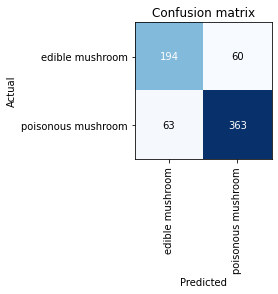

In [87]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [88]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.021682,0.651529,0.266176,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.659622,0.594446,0.235294,01:09
1,0.525015,0.443420,0.180882,01:09
2,0.380032,0.435719,0.170588,01:09
3,0.280074,0.421421,0.163235,01:09


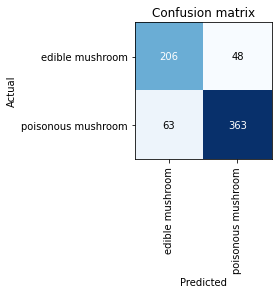

In [89]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [90]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.061257,0.806756,0.264706,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.632404,0.624794,0.229412,01:32
1,0.513028,0.491039,0.201471,01:32
2,0.343577,0.374522,0.142647,01:32
3,0.225250,0.353124,0.142647,01:32


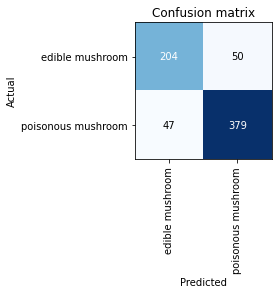

In [91]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [92]:
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.011032,0.709112,0.233824,01:51


epoch,train_loss,valid_loss,error_rate,time
0,0.594506,0.565070,0.210294,02:31
1,0.458608,0.429905,0.142647,02:31
2,0.301170,0.496520,0.150000,02:31
3,0.206643,0.387734,0.122059,02:31


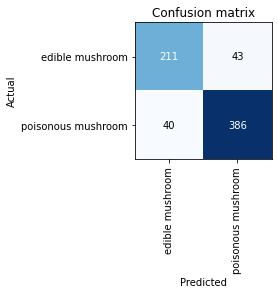

In [93]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [94]:
learn = cnn_learner(dls, resnet152, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()